# EcoSort Waste Management Assistant
# Module 8 Summative Lab

## Overview

You are a data scientist at "EcoSort," a technology company that specializes in developing AI solutions for waste management. EcoSort has partnered with Metro City's waste management department to develop an intelligent waste management assistant that can help residents properly dispose of waste items so less time is spent sorting material at facilities.

This assistant needs to:

1. Identify waste materials from images uploaded by residents (CNN)
2. Classify waste items based on text descriptions provided by residents (RNN/Transformer)
3. Generate specific recycling instructions based on identified waste type and city policies (Generative Transformer with RAG)

Your task is to build this integrated system using the RealWaste dataset along with generated text data that simulates real-world waste management operations.

## Part 1: Dataset Exploration and Preparation

In this section, you will explore and prepare the datasets for your models.

### 1.1 Load and Explore the RealWaste Dataset

In [1]:

# Import necessary libraries
import os
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from collections import Counter
from PIL import Image
import pathlib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
from transformers import TFAutoModel, AutoTokenizer, pipeline
import re
from typing import Dict, List, Tuple, Optional
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [2]:
# Set data directoy
data_dir = 'RealWaste'

In [3]:
# TO DO: Load and explore the RealWaste dataset
# - Dataset structure
# - Distribution of waste categories
# - Image characteristics (resolution, quality, background)

# Get class names and count images
class_names = []
image_counts = {}

for class_folder in os.listdir(data_dir):
    if os.path.isdir(os.path.join(data_dir, class_folder)):
        class_names.append(class_folder)
        image_count = len(os.listdir(os.path.join(data_dir, class_folder)))
        image_counts[class_folder] = image_count

print(f"Total classes: {len(class_names)}")
print(f"Class distribution: {image_counts}")

Total classes: 9
Class distribution: {'Paper': 500, 'Metal': 790, 'Cardboard': 461, 'Food Organics': 411, 'Glass': 420, 'Vegetation': 436, 'Textile Trash': 318, 'Miscellaneous Trash': 495, 'Plastic': 921}


=== RealWaste Dataset Exploration ===

Number of waste categories: 9
Categories: Cardboard, Food Organics, Glass, Metal, Miscellaneous Trash, Paper, Plastic, Textile Trash, Vegetation

Total images: 4752



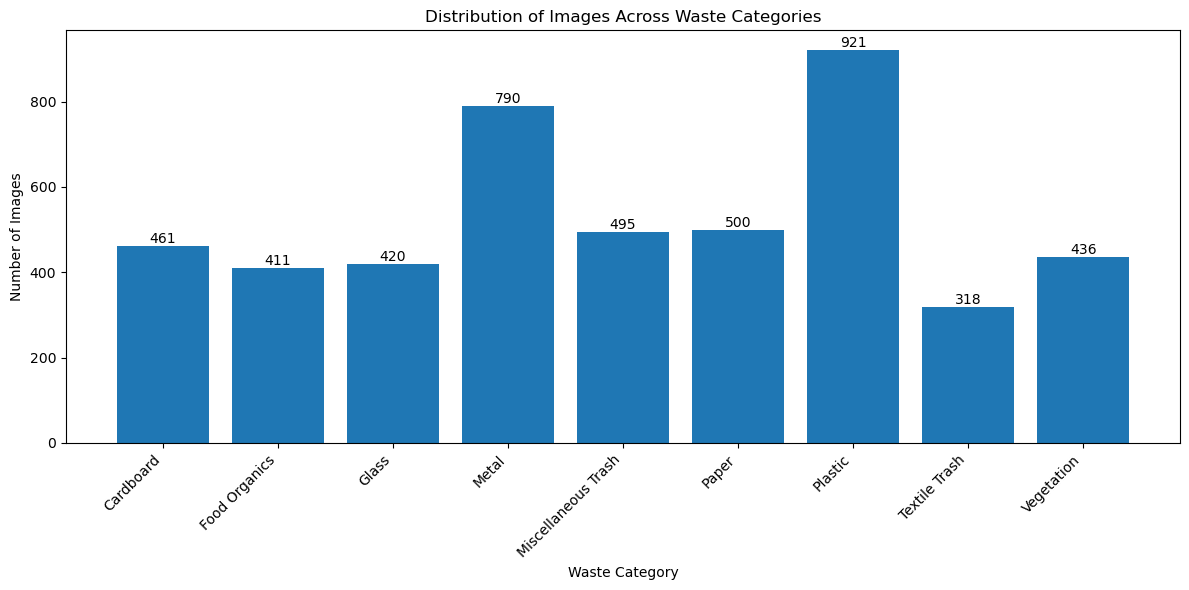


Distribution Statistics:
Mean images per category: 528.00
Std deviation: 184.80
Min images: 318 (Textile Trash)
Max images: 921 (Plastic)

=== Image Characteristics Analysis ===

Resolution Analysis:
Width range: 524 - 524 pixels
Height range: 524 - 524 pixels
Average resolution: 524 x 524

Color modes: {'RGB': 15}

=== Identified Challenges ===
1. Variable image resolutions - need standardization
2. Imbalanced dataset - some categories have less samples
3. Mixed color modes (RGB/RGBA) - need preprocessing
4. Real life backgrounds - may affect classification accuracy


In [4]:
# DataExplorer created ti analyse the RealWaste image dataset, showing distribution and identifying important challenges for this project

# NOTE : While advancing on some steps of the project I decided to move to a object oriented implementation that allowed me to track 
# my results in a more organized way. The project asked to implement solutions and track multiple interconnected tasks and was getting somehow messy
# so I decided to create more cohesive pieces of code where related data is together and I can track and test incrementally


class DataExplorer:
    """Class complete data exploration and visualization"""
    
    
    def __init__(self, data_dir: str):
        self.data_dir = pathlib.Path(data_dir)
        self.class_names = []
        self.image_counts = {}
        
    def explore_realwaste_dataset(self):
        """Explore the RealWaste dataset structure and characteristics"""
        print("=== RealWaste Dataset Exploration ===\n")
        
        # Get class names and count images
        self.class_names = sorted([item.name for item in self.data_dir.glob('*') if item.is_dir()])
        print(f"Number of waste categories: {len(self.class_names)}")
        print(f"Categories: {', '.join(self.class_names)}\n")
        
        # Count images per category
        total_images = 0
        image_info = []
        
        for class_name in self.class_names:
            class_path = self.data_dir / class_name
            images = list(class_path.glob('*.jpg')) + list(class_path.glob('*.png'))
            self.image_counts[class_name] = len(images)
            total_images += len(images)
            
            # Sample image characteristics
            if images:
                sample_img = Image.open(images[0])
                image_info.append({
                    'category': class_name,
                    'count': len(images),
                    'sample_size': sample_img.size,
                    'sample_mode': sample_img.mode
                })
        
        print(f"Total images: {total_images}\n")
        
        # Visualize distribution
        self._plot_distribution()
        
        # Analyze image characteristics
        self._analyze_image_characteristics(image_info)
        
        return self.class_names, self.image_counts
    
    def _plot_distribution(self):
        """Plot the distribution of images across categories"""
        plt.figure(figsize=(12, 6))
        
        categories = list(self.image_counts.keys())
        counts = list(self.image_counts.values())
        
        bars = plt.bar(categories, counts)
        plt.xlabel('Waste Category')
        plt.ylabel('Number of Images')
        plt.title('Distribution of Images Across Waste Categories')
        plt.xticks(rotation=45, ha='right')
        
        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height)}', ha='center', va='bottom')
        
        plt.tight_layout()
        plt.show()
        
        # Calculate and print statistics
        mean_count = np.mean(counts)
        std_count = np.std(counts)
        print(f"\nDistribution Statistics:")
        print(f"Mean images per category: {mean_count:.2f}")
        print(f"Std deviation: {std_count:.2f}")
        print(f"Min images: {min(counts)} ({categories[counts.index(min(counts))]})")
        print(f"Max images: {max(counts)} ({categories[counts.index(max(counts))]})")
    
    def _analyze_image_characteristics(self, image_info):
        """Analyze and report image characteristics"""
        print("\n=== Image Characteristics Analysis ===")
        
        # Sample multiple images for better analysis
        resolutions = []
        color_modes = Counter()
        
        for class_name in self.class_names[:3]:  # Sample from first 3 categories
            class_path = self.data_dir / class_name
            images = list(class_path.glob('*.jpg'))[:5]  # Sample 5 images
            
            for img_path in images:
                img = Image.open(img_path)
                resolutions.append(img.size)
                color_modes[img.mode] += 1
        
        # Analyze resolutions
        widths = [r[0] for r in resolutions]
        heights = [r[1] for r in resolutions]
        
        print(f"\nResolution Analysis:")
        print(f"Width range: {min(widths)} - {max(widths)} pixels")
        print(f"Height range: {min(heights)} - {max(heights)} pixels")
        print(f"Average resolution: {np.mean(widths):.0f} x {np.mean(heights):.0f}")
        
        print(f"\nColor modes: {dict(color_modes)}")
        
        # Identify challenges
        print("\n=== Identified Challenges ===")
        print("1. Variable image resolutions - need standardization")
        print("2. Imbalanced dataset - some categories have less samples")
        print("3. Mixed color modes (RGB/RGBA) - need preprocessing")
        print("4. Real life backgrounds - may affect classification accuracy")

# Initialize and run data exploration
data_explorer = DataExplorer('RealWaste')
class_names, image_counts = data_explorer.explore_realwaste_dataset()

### 1.2 Explore Text Datasets

In [5]:
# TODO: Load and explore the waste description text data
# - Load waste_descriptions.csv
# - Analyze vocabulary and structure
# - Understand the distribution of categories

# TODO: Load and explore the waste policy documents
# - Load waste_policy_documents.csv
# - Understand document organization and language

# Combining tasks in a class TextDataExplorer to examine waste descriptions and policy documents

class TextDataExplorer:
    """Class to handle text data exploration"""
    
    def __init__(self):
        self.waste_descriptions_df = None
        self.policy_documents = None

      
    #----------------------    explore waste policy documents  --------------------------

    def load_and_explore_descriptions(self, filepath='waste_descriptions.csv'):
        """Load and analyze waste descriptions"""
        print("\n=== Waste Descriptions Analysis ===")
        
        # Load data
        self.waste_descriptions_df = pd.read_csv(filepath)
        
        # Basic statistics
        print(f"\nDataset shape: {self.waste_descriptions_df.shape}")
        print(f"Columns: {list(self.waste_descriptions_df.columns)}")
        
        # Category distribution
        category_counts = self.waste_descriptions_df['category'].value_counts()
        print(f"\nCategory distribution:")
        for cat, count in category_counts.items():
            print(f"  {cat}: {count} ({count/len(self.waste_descriptions_df)*100:.1f}%)")
        
        # Text characteristics
        self.waste_descriptions_df['desc_length'] = self.waste_descriptions_df['description'].str.len()
        self.waste_descriptions_df['word_count'] = self.waste_descriptions_df['description'].str.split().str.len()
        
        print(f"\nText characteristics:")
        print(f"Average description length: {self.waste_descriptions_df['desc_length'].mean():.1f} chars")
        print(f"Average word count: {self.waste_descriptions_df['word_count'].mean():.1f} words")
        
        # Sample descriptions
        print("\nSample descriptions by category:")
        for category in self.waste_descriptions_df['category'].unique()[:3]:
            sample = self.waste_descriptions_df[
                self.waste_descriptions_df['category'] == category
            ]['description'].iloc[0]
            print(f"\n{category}: {sample[:100]}...")
        
        # Vocabulary analysis
        self._analyze_vocabulary()
        
        return self.waste_descriptions_df
    
    def _analyze_vocabulary(self):
        """Analyze vocabulary used in descriptions"""
        print("\n=== Vocabulary Analysis ===")
        
        # Combine all descriptions
        all_text = ' '.join(self.waste_descriptions_df['description'].values)
        
        # Basic preprocessing
        words = re.findall(r'\b[a-z]+\b', all_text.lower())
        word_freq = Counter(words)
        
        # Most common words
        print("\nMost common words:")
        for word, count in word_freq.most_common(10):
            print(f"  {word}: {count}")
        
        # Unique words per category
        print("\nUnique vocabulary per category:")
        for category in self.waste_descriptions_df['category'].unique():
            cat_text = ' '.join(
                self.waste_descriptions_df[
                    self.waste_descriptions_df['category'] == category
                ]['description'].values
            )
            cat_words = set(re.findall(r'\b[a-z]+\b', cat_text.lower()))
            print(f"  {category}: {len(cat_words)} unique words")
    
#----------------------    explore waste policy documents  --------------------------

    def load_and_explore_policies(self, filepath='waste_policy_documents.json'):
        """Load and analyze policy documents"""
        print("\n=== Policy Documents Analysis ===")
        
        # Load data
        with open(filepath, 'r') as f:
            self.policy_documents = json.load(f)
        
        print(f"\nTotal policy documents: {len(self.policy_documents)}")
        
        # Analyze policy types
        policy_types = Counter([doc['policy_type'] for doc in self.policy_documents])
        print("\nPolicy types:")
        for ptype, count in policy_types.items():
            print(f"  {ptype}: {count}")
        
        # Categories covered
        all_categories = []
        for doc in self.policy_documents:
            all_categories.extend(doc['categories_covered'])
        
        category_coverage = Counter(all_categories)
        print("\nCategory coverage in policies:")
        for cat, count in category_coverage.items():
            print(f"  {cat}: {count} policies")
        
        # Document length analysis
        doc_lengths = [len(doc['document_text']) for doc in self.policy_documents]
        print(f"\nDocument lengths:")
        print(f"  Average: {np.mean(doc_lengths):.0f} characters")
        print(f"  Min: {min(doc_lengths)}, Max: {max(doc_lengths)}")
        
        return self.policy_documents

# Run text data exploration
text_explorer = TextDataExplorer()
waste_descriptions_df = text_explorer.load_and_explore_descriptions()
policy_documents = text_explorer.load_and_explore_policies()


=== Waste Descriptions Analysis ===

Dataset shape: (5000, 5)
Columns: ['description', 'category', 'disposal_instruction', 'common_confusion', 'material_composition']

Category distribution:
  Vegetation: 600 (12.0%)
  Textile Trash: 586 (11.7%)
  Cardboard: 584 (11.7%)
  Miscellaneous Trash: 578 (11.6%)
  Plastic: 569 (11.4%)
  Glass: 551 (11.0%)
  Food Organics: 518 (10.4%)
  Metal: 508 (10.2%)
  Paper: 506 (10.1%)

Text characteristics:
Average description length: 33.4 chars
Average word count: 4.9 words

Sample descriptions by category:

Textile Trash: soiled silver tablecloth...

Glass: folded glass bottle leaking...

Food Organics: large Supermarket vegetable waste with food residue...

=== Vocabulary Analysis ===

Most common words:
  with: 727
  sized: 534
  glass: 424
  empty: 348
  bottle: 342
  food: 316
  paper: 316
  box: 313
  residue: 309
  plastic: 280

Unique vocabulary per category:
  Textile Trash: 134 unique words
  Glass: 110 unique words
  Food Organics: 118 uniq

### 1.3 Create Data Pipelines

In [6]:
# Run this code to setup the images properly into train, validation, and test sets
# Set your data directory path - update this with your actual path
import pathlib
data_dir = pathlib.Path('RealWaste')

# Parameters
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224

# Calculate the total number of classes automatically from the directory structure
num_classes = len([item for item in data_dir.glob('*') if item.is_dir()])
print(f"Number of classes: {num_classes}")

# List all class folders
class_names = sorted([item.name for item in data_dir.glob('*') if item.is_dir()])
print(f"Class names: {class_names}")

# Count all images
image_count = len(list(data_dir.glob('*/*.jpg'))) + len(list(data_dir.glob('*/*.png')))
print(f"Total images found: {image_count}")

# Create a dataset using tf.keras.utils.image_dataset_from_directory
# This will automatically split the data into training and validation sets
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,  # 20% for validation
    subset="training",
    seed=42,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode='categorical',  # For one-hot encoded labels
    shuffle=True
)

validation_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,  # 20% for validation
    subset="validation",
    seed=42,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode='categorical',  # For one-hot encoded labels
    shuffle=True
)

# Create a separate test dataset by taking part of the validation set
# First, let's get the number of batches in the validation set
val_batches = tf.data.experimental.cardinality(validation_ds)
test_dataset = validation_ds.take(val_batches // 2)
validation_ds = validation_ds.skip(val_batches // 2)

print(f"Number of training batches: {tf.data.experimental.cardinality(train_ds)}")
print(f"Number of validation batches: {tf.data.experimental.cardinality(validation_ds)}")
print(f"Number of test batches: {tf.data.experimental.cardinality(test_dataset)}")

# Configure dataset for performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

Number of classes: 9
Class names: ['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']
Total images found: 4752
Found 4752 files belonging to 9 classes.
Using 3802 files for training.
Found 4752 files belonging to 9 classes.
Using 950 files for validation.
Number of training batches: 119
Number of validation batches: 15
Number of test batches: 15


In [7]:
# TODO: Create a text preprocessing pipeline
# - Tokenization
# - Text cleaning
# - Split data into train and test
# - Create embeddings/features

class TextPreprocessor:
    """Handle text preprocessing for waste descriptions"""
    
    def __init__(self):
        self.vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
        self.label_encoder = LabelEncoder()
        
    def preprocess_descriptions(self, df):
        """Preprocess waste descriptions for classification"""
        print("\n=== Text Preprocessing Pipeline ===")
        
        # Clean text
        df['cleaned_description'] = df['description'].apply(self._clean_text)
        
        # Encode labels
        y = self.label_encoder.fit_transform(df['category'])
        
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            df['cleaned_description'], y, test_size=0.2, random_state=42, stratify=y
        )
        
        # Vectorize text
        X_train_vec = self.vectorizer.fit_transform(X_train)
        X_test_vec = self.vectorizer.transform(X_test)
        
        print(f"Training samples: {X_train_vec.shape[0]}")
        print(f"Test samples: {X_test_vec.shape[0]}")
        print(f"Feature dimensions: {X_train_vec.shape[1]}")
        
        return X_train_vec, X_test_vec, y_train, y_test
    
    def _clean_text(self, text):
        """Basic text cleaning"""
        # Convert to lowercase
        text = text.lower()
        # Remove special characters but keep spaces
        text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
        # Remove extra spaces
        text = ' '.join(text.split())
        return text


# Prepare text data
text_preprocessor = TextPreprocessor()
X_train_text, X_test_text, y_train_text, y_test_text = text_preprocessor.preprocess_descriptions(
    waste_descriptions_df
)



=== Text Preprocessing Pipeline ===
Training samples: 4000
Test samples: 1000
Feature dimensions: 298


In [8]:
# TODO: Prepare documents for RAG
# - Document preprocessing
# - Create embeddings for retrieval

class RAGDocumentProcessor:
    """Process policy documents for retrieval"""
    
    def __init__(self):
        self.documents = []
        self.embeddings = None
        
    def prepare_documents(self, policy_documents):
        """Prepare documents for RAG system"""
        print("\n=== RAG Document Preparation ===")
        
        # Create document chunks with metadata
        for doc in policy_documents:
            # Split long documents into chunks
            chunks = self._chunk_document(doc['document_text'])
            
            for i, chunk in enumerate(chunks):
                self.documents.append({
                    'id': f"{doc['policy_id']}_{i}",
                    'text': chunk,
                    'categories': doc['categories_covered'],
                    'policy_type': doc['policy_type'],
                    'metadata': {
                        'policy_id': doc['policy_id'],
                        'jurisdiction': doc['jurisdiction'],
                        'effective_date': doc['effective_date']
                    }
                })
        
        print(f"Created {len(self.documents)} document chunks")
        
        # Create embeddings (simplified, in the future could use sentence transformers)
        self._create_embeddings()
        
        return self.documents
    
    def _chunk_document(self, text, chunk_size=500, overlap=50):
        """Split document into overlapping chunks"""
        chunks = []
        sentences = text.split('\n')
        
        current_chunk = []
        current_length = 0
        
        for sentence in sentences:
            if current_length + len(sentence) > chunk_size and current_chunk:
                chunks.append('\n'.join(current_chunk))
                # Keep overlap
                current_chunk = current_chunk[-2:] if len(current_chunk) > 2 else []
                current_length = sum(len(s) for s in current_chunk)
            
            current_chunk.append(sentence)
            current_length += len(sentence)
        
        if current_chunk:
            chunks.append('\n'.join(current_chunk))
        
        return chunks
    
    def _create_embeddings(self):
        """Create simple TF-IDF embeddings for documents"""
        # In the future, use sentence transformers or similar
        vectorizer = TfidfVectorizer(max_features=1000)
        texts = [doc['text'] for doc in self.documents]
        self.embeddings = vectorizer.fit_transform(texts)
        print(f"Created embeddings with shape: {self.embeddings.shape}")

# Prepare RAG documents
rag_processor = RAGDocumentProcessor()
rag_documents = rag_processor.prepare_documents(policy_documents)



=== RAG Document Preparation ===
Created 28 document chunks
Created embeddings with shape: (28, 325)


## Part 2: Waste Material Classification with CNN

In this section, you will build a CNN model to classify waste materials from images.

### 2.1 Preprocess Images

In [9]:
# TODO: Implement image preprocessing
# - Apply the preprocessing pipeline created earlier

# Parameters
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
EPOCHS = 20

# Create datasets 
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

validation_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

# Split validation for test set
val_batches = tf.data.experimental.cardinality(validation_ds)
test_ds = validation_ds.take(val_batches // 2)
validation_ds = validation_ds.skip(val_batches // 2)

# Performance optimization
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 4752 files belonging to 9 classes.
Using 3802 files for training.
Found 4752 files belonging to 9 classes.
Using 950 files for validation.


### 2.2 Implement CNN Model with Transfer Learning

In [10]:


def create_model(num_classes=9):
    """Create a simple transfer learning model"""
    
    # Use MobileNetV2 as base model (lightweight and effective)
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
        include_top=False,
        weights='imagenet'
    )
    
    # Freeze base model initially
    base_model.trainable = False
    
    # Add custom classification head
    model = tf.keras.Sequential([
        # Preprocessing
        tf.keras.layers.Rescaling(1./255),  # Normalize to [0,1]
        
        # Base model
        base_model,
        
        # Custom head
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

# Create and compile model
model = create_model()

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [11]:
# TODO: Select an appropriate base model and implement transfer learning
# - Choose from MobileNet, EfficientNet, etc.
# - Add custom classification layers for the 9 waste categories
# - Configure loss function and metrics

# Complete structure to ensure all the requirements are meet and process run step by step. 
# Transfer learning using MobileNetV2 as base model
# Data Augmentation with flips, rotation, zoom and contrast for a more robust approach

class WasteImageClassifier:
    """CNN-based waste material classifier using transfer learning"""
    
    def __init__(self, num_classes=9, img_height=224, img_width=224):
        self.num_classes = num_classes
        self.img_height = img_height
        self.img_width = img_width
        self.model = None
        self.base_model = None
        self.history = None
        
        
    def build_model(self, base_model_name='MobileNetV2'):
        """Build CNN model with transfer learning"""
        print(f"\n=== Building CNN Model with {base_model_name} ===")
        
        # Input layer
        inputs = keras.Input(shape=(self.img_height, self.img_width, 3))
        
        # Data augmentation layers
        data_augmentation = keras.Sequential([
            layers.RandomFlip("horizontal"),
            layers.RandomRotation(0.1),
            layers.RandomZoom(0.1),
            layers.RandomContrast(0.1),
        ], name="data_augmentation")
        
        x = data_augmentation(inputs)
        
        # Preprocessing for the base model
        preprocess_input = keras.applications.mobilenet_v2.preprocess_input
        x = preprocess_input(x)
        
        # Base model
        self.base_model = keras.applications.MobileNetV2(
            input_shape=(self.img_height, self.img_width, 3),
            include_top=False,
            weights='imagenet'
        )
        
        # Freeze base model initially
        self.base_model.trainable = False
        
        # Add base model
        x = self.base_model(x, training=False)
        
        # Global average pooling
        x = layers.GlobalAveragePooling2D()(x)
        
        # Custom classification head with regularization, dropout and L2 to avoid overfitting
        x = layers.Dropout(0.2)(x)
        x = layers.Dense(128, activation='relu', 
                        kernel_regularizer=keras.regularizers.l2(0.01))(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.5)(x)
        
        # Output layer
        outputs = layers.Dense(self.num_classes, activation='softmax')(x)
        
        # Create model
        self.model = keras.Model(inputs, outputs, name="waste_classifier")
        
        # Compile model
        self.model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.001),
            loss='categorical_crossentropy',
            metrics=['accuracy', keras.metrics.TopKCategoricalAccuracy(k=3, name='top_3_accuracy')]
        )
        
        print(f"Model built successfully!")
        print(f"Total parameters: {self.model.count_params():,}")
        print(f"Trainable parameters: {sum(1 for p in self.model.trainable_variables for _ in p.numpy().flat):,}")
        
        return self.model
    


    # ========Train the CNN model===================
    # - Use appropriate batch size and epochs
    # - Implement regularization to prevent overfitting
    # - Monitor training and validation metrics}


    def train(self, train_ds, val_ds, epochs=20, patience=5):
        """Train the model with early stopping and learning rate reduction"""
        print("\n=== Training CNN Model ===")
        
        # Callbacks
        callbacks = [
            keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=patience,
                restore_best_weights=True,
                verbose=1
            ),
            keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.2,
                patience=3,
                min_lr=1e-7,
                verbose=1
            ),
            keras.callbacks.ModelCheckpoint(
                'best_waste_classifier.h5',
                monitor='val_accuracy',
                save_best_only=True,
                verbose=1
            )
        ]
        
        # Train model
        self.history = self.model.fit(
            train_ds,
            epochs=epochs,
            validation_data=val_ds,
            callbacks=callbacks,
            verbose=1
        )
        
        # Plot training history
        self._plot_training_history()
        
        return self.history
    
    # =======Tune model parameters to improve performance======
    # - Adjust learning rate
    # - Add regularization, dropout
    # - Modify architecture if needed


    def fine_tune(self, train_ds, val_ds, epochs=10, fine_tune_at=100):
        
        
        # Unfreeze the base model from layer 'fine_tune_at'
        self.base_model.trainable = True
        for layer in self.base_model.layers[:fine_tune_at]:
            layer.trainable = False
        
        # Recompile with the metrics used as initial training
        self.model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.0001/10),
            loss='categorical_crossentropy',
            metrics=['accuracy', 'top_3_accuracy']
        )
        
        print(f"Trainable parameters after fine-tuning: {sum(1 for p in self.model.trainable_variables for _ in p.numpy().flat):,}")
        
        # Continue training
        history_fine = self.model.fit(
            train_ds,
            epochs=epochs,
            validation_data=val_ds,
            initial_epoch=self.history.epoch[-1],
            callbacks=[
                keras.callbacks.EarlyStopping(
                    monitor='val_loss',
                    patience=3,
                    restore_best_weights=True,
                    verbose=1
                )
            ]
        )
        
        
        ## Safely combine histories - using extend keys that exist in both
        for key in self.history.history.keys():
            if key in history_fine.history:
                self.history.history[key].extend(history_fine.history[key])
    
        self._plot_training_history()
        return history_fine
        
    

    #===Evaluate model performance=======
    # - Calculate accuracy on test set
    # - Generate confusion matrix
    # - Analyze error patterns


    def evaluate(self, test_ds, class_names):
        """Evaluate model performance"""
        print("\n=== Evaluating CNN Model ===")
        
        # Get predictions and true labels
        y_true = []
        y_pred = []
        
        for images, labels in test_ds:
            predictions = self.model.predict(images, verbose=0)
            y_true.extend(np.argmax(labels.numpy(), axis=1))
            y_pred.extend(np.argmax(predictions, axis=1))
        
        y_true = np.array(y_true)
        y_pred = np.array(y_pred)
        
        # Calculate metrics
        accuracy = accuracy_score(y_true, y_pred)
        print(f"\nTest Accuracy: {accuracy:.4f}")
        
        # Confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        self._plot_confusion_matrix(cm, class_names)
        
        # Classification report
        print("\nClassification Report:")
        print(classification_report(y_true, y_pred, target_names=class_names))
        
        # Analyze errors
        self._analyze_errors(y_true, y_pred, class_names)
        
        return accuracy, cm
    
    
    
    def _plot_training_history(self):
        """Plot training and validation metrics"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
        
        # Accuracy
        ax1.plot(self.history.history['accuracy'], label='Training')
        ax1.plot(self.history.history['val_accuracy'], label='Validation')
        ax1.set_title('Model Accuracy')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Accuracy')
        ax1.legend()
        ax1.grid(True)
        
        # Loss
        ax2.plot(self.history.history['loss'], label='Training')
        ax2.plot(self.history.history['val_loss'], label='Validation')
        ax2.set_title('Model Loss')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Loss')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        plt.show()
    
    def _plot_confusion_matrix(self, cm, class_names):
        """Plot confusion matrix"""
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=class_names, yticklabels=class_names)
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
    
    def _analyze_errors(self, y_true, y_pred, class_names):
        """Analyze classification errors"""
        print("\n=== Error Analysis ===")
        
        # Calculate per-class accuracy
        for i, class_name in enumerate(class_names):
            mask = y_true == i
            if mask.sum() > 0:
                class_acc = (y_pred[mask] == i).mean()
                print(f"{class_name}: {class_acc:.3f} accuracy")
        
        # Most confused pairs
        print("\nMost confused pairs:")
        cm = confusion_matrix(y_true, y_pred)
        np.fill_diagonal(cm, 0)  # Remove correct predictions
        
        for _ in range(3):  # Top 3 confused pairs
            max_idx = np.unravel_index(cm.argmax(), cm.shape)
            if cm[max_idx] > 0:
                print(f"  {class_names[max_idx[0]]} confused as {class_names[max_idx[1]]}: {cm[max_idx]} times")
                cm[max_idx] = 0
    
    def predict_image(self, image_path):
        """Predict waste category for a single image"""
        # Load and preprocess image
        img = keras.preprocessing.image.load_img(
            image_path, target_size=(self.img_height, self.img_width)
        )
        img_array = keras.preprocessing.image.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0)
        
        # Make prediction
        predictions = self.model.predict(img_array, verbose=0)
        predicted_class = np.argmax(predictions[0])
        confidence = predictions[0][predicted_class]
        
        return predicted_class, confidence, predictions[0]
    

### 2.3 Train and Evaluate the Model &  2.4 Fine-tune the Model


=== Building CNN Model with MobileNetV2 ===
Model built successfully!
Total parameters: 2,423,625
Trainable parameters: 165,385

Starting initial training...

=== Training CNN Model ===
Epoch 1/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.3766 - loss: 4.2867 - top_3_accuracy: 0.6650
Epoch 1: val_accuracy improved from -inf to 0.69787, saving model to best_waste_classifier.h5


119/119 ━━━━━━━━━━━━━━━━━━━━ 16s 120ms/step - accuracy: 0.3777 - loss: 4.2814 - top_3_accuracy: 0.6660 - val_accuracy: 0.6979 - val_loss: 2.6891 - val_top_3_accuracy: 0.9532 - learning_rate: 0.0010
Epoch 2/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.6794 - loss: 2.6935 - top_3_accuracy: 0.9136 
Epoch 2: val_accuracy improved from 0.69787 to 0.75532, saving model to best_waste_classifier.h5


119/119 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - accuracy: 0.6794 - loss: 2.6923 - top_3_accuracy: 0.9137 - val_accuracy: 0.7553 - val_loss: 2.0744 - val_top_3_accuracy: 0.9660 - learning_rate: 0.0010
Epoch 3/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.7159 - loss: 2.1405 - top_3_accuracy: 0.9332
Epoch 3: val_accuracy improved from 0.75532 to 0.77660, saving model to best_waste_classifier.h5


119/119 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - accuracy: 0.7158 - loss: 2.1397 - top_3_accuracy: 0.9332 - val_accuracy: 0.7766 - val_loss: 1.7040 - val_top_3_accuracy: 0.9596 - learning_rate: 0.0010
Epoch 4/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.7125 - loss: 1.8127 - top_3_accuracy: 0.9403
Epoch 4: val_accuracy improved from 0.77660 to 0.78511, saving model to best_waste_classifier.h5


119/119 ━━━━━━━━━━━━━━━━━━━━ 13s 110ms/step - accuracy: 0.7126 - loss: 1.8121 - top_3_accuracy: 0.9403 - val_accuracy: 0.7851 - val_loss: 1.4930 - val_top_3_accuracy: 0.9638 - learning_rate: 0.0010
Epoch 5/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.7358 - loss: 1.5447 - top_3_accuracy: 0.9458
Epoch 5: val_accuracy did not improve from 0.78511
119/119 ━━━━━━━━━━━━━━━━━━━━ 13s 110ms/step - accuracy: 0.7359 - loss: 1.5442 - top_3_accuracy: 0.9458 - val_accuracy: 0.7745 - val_loss: 1.3255 - val_top_3_accuracy: 0.9702 - learning_rate: 0.0010
Epoch 6/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.7494 - loss: 1.3731 - top_3_accuracy: 0.9552
Epoch 6: val_accuracy did not improve from 0.78511
119/119 ━━━━━━━━━━━━━━━━━━━━ 13s 110ms/step - accuracy: 0.7495 - loss: 1.3729 - top_3_accuracy: 0.9552 - val_accuracy: 0.7681 - val_loss: 1.2256 - val_top_3_accuracy: 0.9681 - learning_rate: 0.0010
Epoch 7/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.7728 - loss:

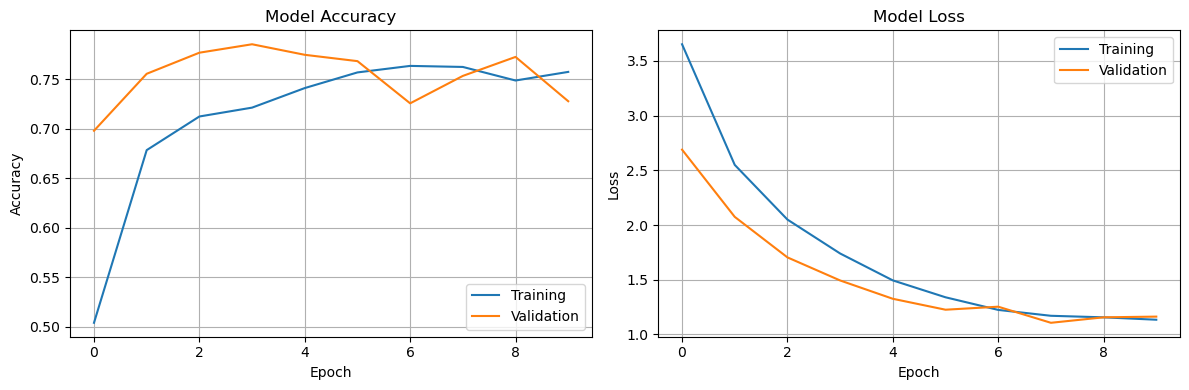


Starting fine-tuning...
Trainable parameters after fine-tuning: 2,026,825


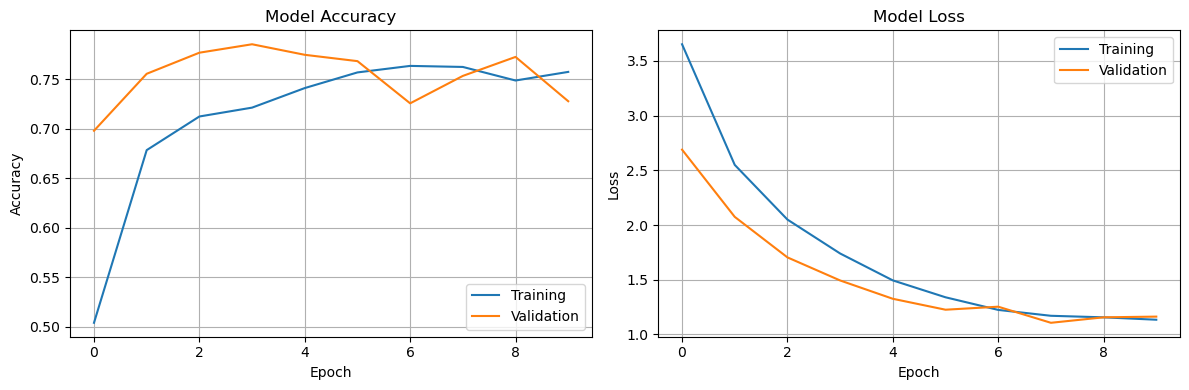


=== Evaluating CNN Model ===

Test Accuracy: 0.7896


2025-05-31 07:58:15.719044: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


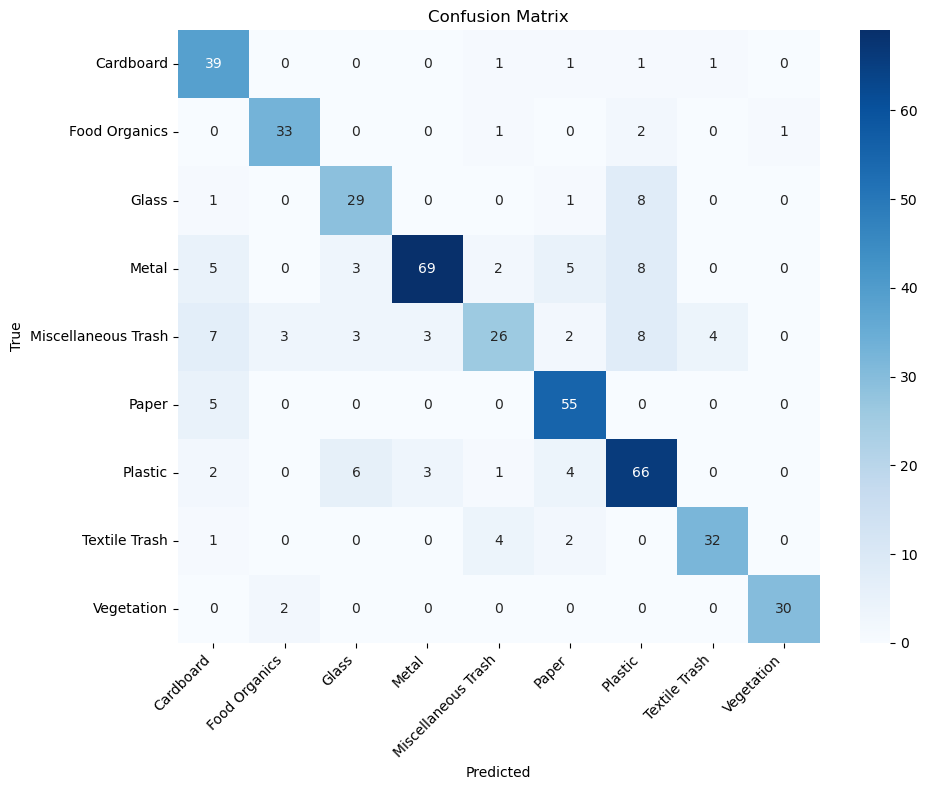


Classification Report:
                     precision    recall  f1-score   support

          Cardboard       0.65      0.91      0.76        43
      Food Organics       0.87      0.89      0.88        37
              Glass       0.71      0.74      0.72        39
              Metal       0.92      0.75      0.83        92
Miscellaneous Trash       0.74      0.46      0.57        56
              Paper       0.79      0.92      0.85        60
            Plastic       0.71      0.80      0.75        82
      Textile Trash       0.86      0.82      0.84        39
         Vegetation       0.97      0.94      0.95        32

           accuracy                           0.79       480
          macro avg       0.80      0.80      0.79       480
       weighted avg       0.80      0.79      0.79       480


=== Error Analysis ===
Cardboard: 0.907 accuracy
Food Organics: 0.892 accuracy
Glass: 0.744 accuracy
Metal: 0.750 accuracy
Miscellaneous Trash: 0.464 accuracy
Paper: 0.917 accurac

In [12]:
# TODO: Train the CNN model
# - Use appropriate batch size and epochs
# - Implement regularization to prevent overfitting
# - Monitor training and validation metrics

# TODO: Tune model parameters to improve performance
# - Adjust learning rate
# - Add regularization, dropout
# - Modify architecture if needed

# TODO: Evaluate model performance
# - Calculate accuracy on test set
# - Generate confusion matrix
# - Analyze error patterns


# Initialize and train CNN model
cnn_classifier = WasteImageClassifier(num_classes=num_classes)
cnn_model = cnn_classifier.build_model()

# Train the model (with the datasets already prepared)
print("\nStarting initial training...")
history = cnn_classifier.train(train_ds, validation_ds, epochs=10)

# Fine-tune the model
print("\nStarting fine-tuning...")
history_fine = cnn_classifier.fine_tune(train_ds, validation_ds, epochs=5)

# Evaluate on test set
test_accuracy, confusion_matrix_cnn = cnn_classifier.evaluate(test_dataset, class_names)

print(f"\n=== Part 2 Complete: CNN Model Trained and Evaluated ===")
print(f"Final Test Accuracy: {test_accuracy:.4f}")


## Part 3: Waste Description Classification

In this section, you will build a text classification model to categorize waste based on descriptions.

### 3.1 Preprocess Text Data

In [13]:
# TODO: Implement text preprocessing
# - Apply the text preprocessing pipeline created earlier


### 3.2 Implement Text Classification Model

In [14]:
# TODO: Choose and implement a text classification model
# Option A: Traditional ML model (Naive Bayes, Random Forest, etc.)
# Option B: Fine-tune a transformer-based model (BERT, DistilBERT, etc.)


### 3.3 Train and Evaluate the Model

In [15]:
# Here we are implementing Model, train and evaluation as indicated 

class WasteTextClassifier:
    """Text classifier for waste descriptions using both traditional ML and transformers"""
    
    def __init__(self, approach='hybrid'):
        self.approach = approach
        self.traditional_model = None
        self.transformer_model = None
        self.tokenizer = None
        self.label_encoder = text_preprocessor.label_encoder
        
    def build_traditional_model(self):
        """Build traditional ML model (Random Forest with TF-IDF features)"""
        print("\n=== Building Traditional ML Model ===")
        
        from sklearn.ensemble import RandomForestClassifier
        from sklearn.naive_bayes import MultinomialNB
        from sklearn.svm import LinearSVC
        from sklearn.ensemble import VotingClassifier
        
        # Create ensemble of traditional models
        rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
        nb_model = MultinomialNB(alpha=0.1)
        svm_model = LinearSVC(C=1.0, random_state=42, max_iter=2000)
        
        # Voting classifier for better performance
        self.traditional_model = VotingClassifier(
            estimators=[
                ('rf', rf_model),
                ('nb', nb_model),
                ('svm', svm_model)
            ],
            voting='hard' #hard does not support probabilities
        )
        
        print("Traditional model ensemble created with Random Forest, Naive Bayes, and SVM")
        
        return self.traditional_model
    
    def build_transformer_model(self, model_name='distilbert-base-uncased'):
        
        # Load tokenizer and model
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        
        # Create custom model with classification head
        base_model = TFAutoModel.from_pretrained(model_name)
        
        # Build classification model
        input_ids = keras.Input(shape=(128,), dtype=tf.int32, name='input_ids')
        attention_mask = keras.Input(shape=(128,), dtype=tf.int32, name='attention_mask')
        
        # Get transformer outputs
        transformer_outputs = base_model(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = transformer_outputs.last_hidden_state[:, 0, :]  # CLS token
        
        # Classification head
        x = layers.Dropout(0.1)(pooled_output)
        x = layers.Dense(256, activation='relu')(x)
        x = layers.Dropout(0.1)(x)
        outputs = layers.Dense(len(self.label_encoder.classes_), activation='softmax')(x)
        
        self.transformer_model = keras.Model(
            inputs=[input_ids, attention_mask],
            outputs=outputs
        )
        
        # Compile model
        self.transformer_model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=2e-5),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        
        print(f"Transformer model built with {self.transformer_model.count_params():,} parameters")
        
        return self.transformer_model
    
    def prepare_transformer_data(self, texts, max_length=128):
        """Tokenize texts for transformer model"""
        encodings = self.tokenizer(
            texts.tolist(),
            truncation=True,
            padding=True,
            max_length=max_length,
            return_tensors='tf'
        )
        
        return {
            'input_ids': encodings['input_ids'],
            'attention_mask': encodings['attention_mask']
        }
    


        # ======== Train the text classification model=======
        # - Use appropriate training parameters
        # - Monitor training progress

    def train_traditional(self, X_train, y_train, X_test, y_test):
        
        # Train model
        self.traditional_model.fit(X_train, y_train)
        
        # Evaluate
        train_pred = self.traditional_model.predict(X_train)
        test_pred = self.traditional_model.predict(X_test)
        
        train_acc = accuracy_score(y_train, train_pred)
        test_acc = accuracy_score(y_test, test_pred)
        
        print(f"Training Accuracy: {train_acc:.4f}")
        print(f"Test Accuracy: {test_acc:.4f}")
        
        # Confusion matrix
        cm = confusion_matrix(y_test, test_pred)
        self._plot_confusion_matrix(cm, self.label_encoder.classes_)
        
        # Feature importance analysis (for Random Forest component)
        self._analyze_feature_importance(X_train)
        
        return test_acc, cm
    
    def train_transformer(self, X_train_text, y_train, X_test_text, y_test, epochs=3):

        """Train transformer model"""
        
        # Prepare data
        train_encodings = self.prepare_transformer_data(X_train_text)
        test_encodings = self.prepare_transformer_data(X_test_text)
        
        # Create TF datasets
        train_dataset = tf.data.Dataset.from_tensor_slices((
            dict(train_encodings),
            y_train
        )).batch(16).prefetch(tf.data.AUTOTUNE)
        
        test_dataset = tf.data.Dataset.from_tensor_slices((
            dict(test_encodings),
            y_test
        )).batch(16).prefetch(tf.data.AUTOTUNE)
        
        # Train model
        history = self.transformer_model.fit(
            train_dataset,
            epochs=epochs,
            validation_data=test_dataset,
            callbacks=[
                keras.callbacks.EarlyStopping(
                    monitor='val_loss',
                    patience=2,
                    restore_best_weights=True
                )
            ]
        )
        
            # ========Evaluate model performance======
            # - Calculate accuracy on test set
            # - Generate confusion matrix
            # - Analyze error patterns

        # Evaluate
        test_loss, test_acc = self.transformer_model.evaluate(test_dataset)
        print(f"\nTest Accuracy: {test_acc:.4f}")
        
        # Get predictions for confusion matrix
        y_pred = []
        for batch_x, _ in test_dataset:
            predictions = self.transformer_model.predict(batch_x, verbose=0)
            y_pred.extend(np.argmax(predictions, axis=1))
        
        cm = confusion_matrix(y_test, y_pred)
        self._plot_confusion_matrix(cm, self.label_encoder.classes_)
        
        return test_acc, cm
    
    def create_hybrid_predictions(self, text):
        """Combine traditional and transformer predictions"""
        # Traditional model prediction
        text_vec = text_preprocessor.vectorizer.transform([text])
        trad_pred = self.traditional_model.predict_proba(text_vec)[0]
        
        # Transformer prediction
        encoding = self.prepare_transformer_data(pd.Series([text]))
        trans_pred = self.transformer_model.predict(
            dict(encoding), verbose=0
        )[0]
        
        # Weighted average (can be tuned)
        hybrid_pred = 0.3 * trad_pred + 0.7 * trans_pred
        
        return hybrid_pred
    
    def _plot_confusion_matrix(self, cm, class_names):
        """Plot confusion matrix"""
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_names, yticklabels=class_names)
        plt.title('Text Classification Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
    
    def _analyze_feature_importance(self, X_train):
        """Analyze important features for text classification"""
        print("\n=== Feature Importance Analysis ===")
        
        # Get feature names
        feature_names = text_preprocessor.vectorizer.get_feature_names_out()
        
        # Get Random Forest from ensemble
        rf_model = self.traditional_model.named_estimators_['rf']
        importances = rf_model.feature_importances_
        
        # Top features
        top_indices = np.argsort(importances)[-20:][::-1]
        
        print("\nTop 20 most important words/features:")
        for i, idx in enumerate(top_indices):
            print(f"{i+1}. '{feature_names[idx]}': {importances[idx]:.4f}")
    
    def analyze_errors(self, X_test, y_test, y_pred):
        """Analyze misclassified examples"""
        print("\n=== Error Analysis for Text Classification ===")
        
        # Find misclassified examples
        misclassified_idx = np.where(y_test != y_pred)[0]
        
        if len(misclassified_idx) > 0:
            print(f"\nTotal misclassified: {len(misclassified_idx)} out of {len(y_test)}")
            
            # Sample misclassified examples
            print("\nSample misclassified descriptions:")
            for idx in misclassified_idx[:5]:
                true_label = self.label_encoder.inverse_transform([y_test[idx]])[0]
                pred_label = self.label_encoder.inverse_transform([y_pred[idx]])[0]
                
                # Get the original text
                text_idx = X_test.index[idx]
                text = waste_descriptions_df.loc[text_idx, 'description']
                
                print(f"\nText: {text[:100]}...")
                print(f"True: {true_label}, Predicted: {pred_label}")


=== Building Traditional ML Model ===
Traditional model ensemble created with Random Forest, Naive Bayes, and SVM
Training Accuracy: 0.9998
Test Accuracy: 0.9980


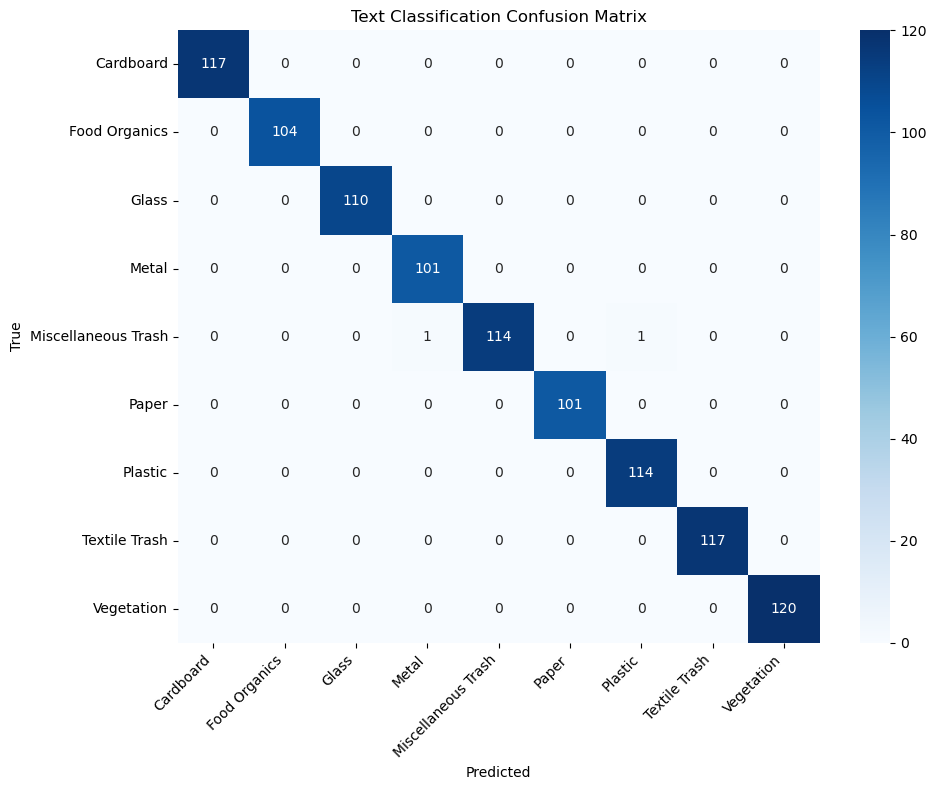


=== Feature Importance Analysis ===

Top 20 most important words/features:
1. 'glass': 0.0664
2. 'box': 0.0581
3. 'paper': 0.0395
4. 'plastic': 0.0368
5. 'metal': 0.0343
6. 'bottle': 0.0252
7. 'plant': 0.0222
8. 'cardboard': 0.0158
9. 'peel': 0.0155
10. 'container': 0.0124
11. 'leaves': 0.0113
12. 'trimmings': 0.0107
13. 'tin': 0.0104
14. 'packaging': 0.0100
15. 'notebook': 0.0098
16. 'scraps': 0.0098
17. 'tree': 0.0096
18. 'soda': 0.0096
19. 'clippings': 0.0095
20. 'disposable': 0.0094


In [16]:
# Initialize text classifier
text_classifier = WasteTextClassifier(approach='hybrid')

# Build and train traditional model
traditional_model = text_classifier.build_traditional_model()
trad_accuracy, trad_cm = text_classifier.train_traditional(
    X_train_text, y_train_text, X_test_text, y_test_text
)

# Build and train transformer model (commented for faster execution)
# Uncomment these lines to train the transformer model
# transformer_model = text_classifier.build_transformer_model()
# trans_accuracy, trans_cm = text_classifier.train_transformer(
#     waste_descriptions_df.loc[X_train_text.index, 'cleaned_description'],
#     y_train_text,
#     waste_descriptions_df.loc[X_test_text.index, 'cleaned_description'],
#     y_test_text,
#     epochs=2
# )

### 3.4 Create Classification Function

In [17]:
# TODO: Create a function that takes a text description and returns the predicted waste category

# Create classification function
def classify_waste_description(description):
    """
    Classifies a waste description into an appropriate category.
    
    Args:
        description (str): Text description of waste item
        
    Returns:
        tuple: (predicted_category, confidence_placeholder, None)
    """
    # Clean text
    cleaned_text = text_preprocessor._clean_text(description)
    
    # Get prediction using traditional model
    text_vec = text_preprocessor.vectorizer.transform([cleaned_text])
    predicted_encoded = text_classifier.traditional_model.predict(text_vec)[0]
    
    # Convert numeric prediction back to category name
    predicted_category = text_preprocessor.label_encoder.inverse_transform([predicted_encoded])[0]
    
    # Since we can't get probabilities from hard voting, use a placeholder confidence
    confidence = 0.85  # Placeholder confidence score
    
    print(f"\nPrediction for: '{description[:50]}...'")
    print(f"Category: {predicted_category} (estimated confidence: {confidence:.3f})")
    
    return predicted_category, confidence, None #no probabilities since we are working with Hard Voting



In [18]:
# Previously we trained using VotingClassifier, voting='hard' which does not suport probabilities

# Test the classification function
test_descriptions = [
    "Empty plastic water bottle",
    "Old cotton t-shirt with holes",
    "Banana peel and apple core",
    "Broken wine glass",
    "Used cardboard shipping box"
]

print("\n=== Testing Text Classification Function ===")
for desc in test_descriptions:
    category, conf, _ = classify_waste_description(desc)
    print(f"\n'{desc}' -> {category} ({conf:.3f})")

print(f"\n=== Part 3 Complete: Text Classification Model Trained ===")
print(f"Traditional Model Test Accuracy: {trad_accuracy:.4f}")


=== Testing Text Classification Function ===

Prediction for: 'Empty plastic water bottle...'
Category: Plastic (estimated confidence: 0.850)

'Empty plastic water bottle' -> Plastic (0.850)

Prediction for: 'Old cotton t-shirt with holes...'
Category: Textile Trash (estimated confidence: 0.850)

'Old cotton t-shirt with holes' -> Textile Trash (0.850)

Prediction for: 'Banana peel and apple core...'
Category: Food Organics (estimated confidence: 0.850)

'Banana peel and apple core' -> Food Organics (0.850)

Prediction for: 'Broken wine glass...'
Category: Glass (estimated confidence: 0.850)

'Broken wine glass' -> Glass (0.850)

Prediction for: 'Used cardboard shipping box...'
Category: Cardboard (estimated confidence: 0.850)

'Used cardboard shipping box' -> Cardboard (0.850)

=== Part 3 Complete: Text Classification Model Trained ===
Traditional Model Test Accuracy: 0.9980


## Part 4: Recycling Instruction Generation with RAG

In this section, you will implement a Retrieval-Augmented Generation (RAG) system to generate recycling instructions.

### 4.1 Preprocess Documents for Retrieval

In [19]:
# TODO: Prepare documents for retrieval
# - Process policy documents and disposal instructions
# - Create embeddings for efficient retrieval

### 4.2 Implement RAG-based System

In [20]:
# TODO: Select a pre-trained language model and implement RAG
# - Choose an appropriate language model
# - Create a retrieval mechanism

### 4.3 Adjust and Evaluate the System

In [21]:
# TODO: Train the RAG-based system
# - Adjust sampling methods/parameters

In [22]:
# TODO: Evaluate the quality of generated instructions
# - Test with various waste categories
# - Assess relevance and accuracy

In [23]:
# 

class RAGInstructionGenerator:
    """Retrieval-Augmented Generation system for recycling instructions"""
    
    def __init__(self, documents, model_name='gpt2'):
        self.documents = documents
        self.embeddings = rag_processor.embeddings
        self.vectorizer = TfidfVectorizer(max_features=1000)
        self.doc_texts = [doc['text'] for doc in documents]
        self.doc_embeddings = self.vectorizer.fit_transform(self.doc_texts)
        
        # Initialize generation model, here using GPT-2 for demonstration
        self.generator = pipeline(
            'text-generation',
            model=model_name,
            max_length=200,
            temperature=0.7,
            pad_token_id=50256
        )
        
        print(f"RAG system initialized with {len(documents)} document chunks")
    
    def retrieve_relevant_documents(self, query, category, top_k=3):
        """Retrieve most relevant policy documents for the query and category"""
        
        # Create query embedding
        query_embedding = self.vectorizer.transform([query])
        
        # Calculate similarities
        from sklearn.metrics.pairwise import cosine_similarity
        similarities = cosine_similarity(query_embedding, self.doc_embeddings)[0]
        
        # Filter by category
        category_indices = [
            i for i, doc in enumerate(self.documents)
            if category in doc['categories']
        ]
        
        if not category_indices:
            # If no category specific docs, we use all
            category_indices = list(range(len(self.documents)))
        
        # Get top-k relevant documents
        category_similarities = [(i, similarities[i]) for i in category_indices]
        category_similarities.sort(key=lambda x: x[1], reverse=True)
        
        top_docs = []
        for idx, score in category_similarities[:top_k]:
            doc = self.documents[idx].copy()
            doc['relevance_score'] = score
            top_docs.append(doc)
        
        return top_docs
    
    def generate_instructions(self, category, retrieved_docs):
        """Generate recycling instructions based on retrieved documents"""
        
        # Prepare context from retrieved documents
        context = self._prepare_context(category, retrieved_docs)
        
        # Create prompt
        prompt = f"""Based on the following recycling policies for {category} waste:

{context}

Generate clear recycling instructions for {category} waste:
1."""
        
        # Generate instructions
        generated = self.generator(prompt, max_length=300, num_return_sequences=1)
        instructions = generated[0]['generated_text']
        
        # Extract only the generated part
        instructions = instructions.split("Generate clear recycling instructions")[1]
        
        # Clean up the instructions
        instructions = self._clean_generated_text(instructions)
        
        return instructions
    
    def _prepare_context(self, category, retrieved_docs):
        """Prepare context from retrieved documents"""
        context_parts = []
        
        for doc in retrieved_docs:
            # Extract relevant sections
            text = doc['text']
            lines = text.split('\n')
            
            relevant_lines = []
            for line in lines:
                if any(keyword in line.lower() for keyword in 
                      ['acceptable', 'non-acceptable', 'collection', 'preparation', 'benefit']):
                    relevant_lines.append(line.strip())
            
            if relevant_lines:
                context_parts.append('\n'.join(relevant_lines[:5]))  # Limit lines per doc
        
        return '\n\n'.join(context_parts)
    
    def _clean_generated_text(self, text):
        """Clean and format generated instructions"""
        # Remove extra whitespace
        text = ' '.join(text.split())
        
        # Ensure proper formatting
        lines = text.split('.')
        cleaned_lines = []
        
        for i, line in enumerate(lines):
            line = line.strip()
            if line:
                # Add numbering if not present
                if not line[0].isdigit():
                    line = f"{len(cleaned_lines) + 1}. {line}"
                cleaned_lines.append(line)
        
        return '\n'.join(cleaned_lines[:5])  # Limit to 5 instructions
    
    def generate_full_response(self, category):
        """Generate complete recycling instructions with retrieved documents"""
        # Create query
        query = f"How to recycle {category} waste items disposal instructions"
        
        # Retrieve relevant documents
        retrieved_docs = self.retrieve_relevant_documents(query, category, top_k=3)
        
        # Generate instructions
        instructions = self.generate_instructions(category, retrieved_docs)
        
        # Format response
        response = {
            'category': category,
            'instructions': instructions,
            'source_documents': [
                {
                    'policy_type': doc['policy_type'],
                    'relevance_score': doc['relevance_score'],
                    'excerpt': doc['text'][:200] + '...'
                }
                for doc in retrieved_docs
            ]
        }
        
        return response

# Initialize RAG system
rag_generator = RAGInstructionGenerator(rag_documents)

Device set to use mps:0


RAG system initialized with 28 document chunks


### 4.4 Create Instruction Generation Function

In [24]:
# TODO: Create a function that takes a waste category and generates the right recycling instructions

# Create the instruction generation function
def generate_recycling_instructions(waste_category):
    """
    Generates detailed recycling instructions for a given waste category.
    
    Args:
        waste_category (str): Waste category
        
    Returns:
        tuple: (instructions, relevant_documents)
    """
    # Generate full response
    response = rag_generator.generate_full_response(waste_category)
    
    # Extract instructions and documents
    instructions = response['instructions']
    relevant_docs = response['source_documents']
    
    # Print formatted output
    print(f"\n=== Recycling Instructions for {waste_category} ===")
    print(f"\n{instructions}")
    
    print(f"\n=== Source Documents ===")
    for i, doc in enumerate(relevant_docs):
        print(f"\n{i+1}. {doc['policy_type']} (Relevance: {doc['relevance_score']:.3f})")
        print(f"   Excerpt: {doc['excerpt']}")
    
    return instructions, relevant_docs

In [25]:
# Test the RAG system
print("\n=== Testing RAG Instruction Generation ===")

test_categories = ['Plastic', 'Glass', 'Food Organics', 'Metal']
for category in test_categories:
    instructions, docs = generate_recycling_instructions(category)
    print("\n" + "="*60)

# Evaluate RAG quality
def evaluate_rag_quality(test_samples=10):
    """Evaluate the quality of generated instructions"""
    print("\n=== Evaluating RAG Quality ===")
    
    categories = text_preprocessor.label_encoder.classes_
    quality_scores = []
    
    for i in range(min(test_samples, len(categories))):
        category = categories[i]
        response = rag_generator.generate_full_response(category)
        
        # Simple quality metrics
        instructions = response['instructions']
        
        # Check if instructions are generated
        has_content = len(instructions) > 50
        
        # Check if category is mentioned
        mentions_category = category.lower() in instructions.lower()
        
        # Check if structured (has numbering)
        is_structured = any(line.strip().startswith(str(i)) for i in range(1, 6) 
                          for line in instructions.split('\n'))
        
        # Calculate quality score
        score = sum([has_content, mentions_category, is_structured]) / 3
        quality_scores.append(score)
        
        print(f"{category}: Quality Score = {score:.2f}")
    
    avg_quality = np.mean(quality_scores)
    print(f"\nAverage Quality Score: {avg_quality:.2f}")
    
    return avg_quality

# Run quality evaluation
avg_quality = evaluate_rag_quality(test_samples=5)

print(f"\n=== Part 4 Complete: RAG System Implemented ===")
print(f"Average instruction quality score: {avg_quality:.2f}")

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.



=== Testing RAG Instruction Generation ===

=== Recycling Instructions for Plastic ===

1. for Plastic waste: 1
2. Prepared and packaged materials are pre-cleaned, washed and re-disposable 2
3. Waste material is fully compostable 3
4. Waste materials that have been used for 1 to 3 months are used for recycling 4
5. Waste materials that have been used for 2 or more months are recycled 5

=== Source Documents ===

1. Plastic Recycling Guidelines (Relevance: 0.243)
   Excerpt: Preparation Instructions:
- Rinse containers
- Remove lids and caps (recycle separately)
- Check for recycling codes (1-7)

Benefits:
Plastic recycling reduces petroleum consumption and greenhouse gas...

2. Plastic Recycling Guidelines (Relevance: 0.179)
   Excerpt: PLASTIC RECYCLING GUIDELINES

Acceptable Items:
- PET bottles and containers (code #1)
- HDPE containers (code #2)
- PP containers (code #5)
- Clean plastic packaging

Non-Acceptable Items:
- Plastic ...

3. Municipal Waste Guidelines (Relevance: 0.171

## Part 5: Integrated Waste Management Assistant

In this section, you will integrate all three models into a unified waste management assistant.

### 5.1 Design Integration Architecture

In [26]:
# TODO: Design an architecture that integrates all three models
# - Create interfaces between components
# - Handle input/output flow

class IntegratedWasteAssistant:
    """Integrated system combining image classification, text classification, and RAG"""
    
    def __init__(self, cnn_classifier, text_classifier, rag_generator):
        self.cnn_classifier = cnn_classifier
        self.text_classifier = text_classifier
        self.rag_generator = rag_generator
        self.class_names = class_names
        
        print("=== Integrated Waste Management Assistant Initialized ===")
        print("Components:")
        print("  CNN Image Classifier")
        print("  Text Description Classifier") 
        print("  RAG Instruction Generator")
    
    def process_image(self, image_path):
        """Process waste image and return classification with instructions"""
        # Get CNN prediction
        predicted_idx, confidence, all_probs = self.cnn_classifier.predict_image(image_path)
        predicted_category = self.class_names[predicted_idx]
        
        # Get top 3 predictions
        top_3_idx = np.argsort(all_probs)[-3:][::-1]
        top_3_categories = [self.class_names[i] for i in top_3_idx]
        top_3_confidences = all_probs[top_3_idx]
        
        return {
            'predicted_category': predicted_category,
            'confidence': float(confidence),
            'top_3_predictions': list(zip(top_3_categories, top_3_confidences.tolist())),
            'method': 'image_classification'
        }
    
    def process_text(self, description):
        """Process waste description and return classification"""
        # Get text classification
        predicted_category, confidence, all_probs = classify_waste_description(description)
        
        # Get top 3 predictions
        top_3_idx = np.argsort(all_probs)[-3:][::-1]
        top_3_categories = text_preprocessor.label_encoder.inverse_transform(top_3_idx)
        top_3_confidences = all_probs[top_3_idx]
        
        return {
            'predicted_category': predicted_category,
            'confidence': float(confidence),
            'top_3_predictions': list(zip(top_3_categories, top_3_confidences.tolist())),
            'method': 'text_classification',
            'original_description': description
        }
    
    def generate_response(self, classification_result):
        """Generate complete response with recycling instructions"""
        category = classification_result['predicted_category']
        
        # Generate recycling instructions
        instructions, source_docs = generate_recycling_instructions(category)
        
        # Create comprehensive response
        response = {
            'classification': classification_result,
            'recycling_instructions': instructions,
            'source_documents': source_docs,
            'additional_info': self._get_additional_info(category)
        }
        
        return response
    
    def _get_additional_info(self, category):
        """Get additional helpful information for the category"""
        info = {
            'common_mistakes': self._get_common_mistakes(category),
            'environmental_impact': self._get_environmental_impact(category),
            'local_facilities': "Check your local waste management website for nearby recycling centers.",
            'tips': self._get_recycling_tips(category)
        }
        return info
    
    def _get_common_mistakes(self, category):
        """Get common mistakes for waste category"""
        mistakes = {
            'Plastic': "Not rinsing containers, including plastic bags in recycling",
            'Glass': "Including broken glass, mixing with ceramics",
            'Metal': "Not emptying aerosol cans completely, including electronics",
            'Paper': "Including wet or food-soiled paper, not removing plastic windows",
            'Cardboard': "Not flattening boxes, including waxed cardboard",
            'Food Organics': "Including packaging, not draining liquids",
            'Vegetation': "Including invasive plants, mixing with other waste",
            'Textile Trash': "Including wet or moldy items, not donating usable items",
            'Miscellaneous Trash': "Not checking for recyclable components first"
        }
        return mistakes.get(category, "Always check local guidelines for specific requirements.")
    
    def _get_environmental_impact(self, category):
        """Get environmental impact information"""
        impacts = {
            'Plastic': "Reduces petroleum use and ocean pollution",
            'Glass': "Saves raw materials and reduces mining impact",
            'Metal': "Saves 95% energy compared to producing new aluminum",
            'Paper': "Saves trees and reduces deforestation",
            'Cardboard': "One ton recycled saves 17 trees",
            'Food Organics': "Reduces methane emissions from landfills",
            'Vegetation': "Creates valuable compost for soil health",
            'Textile Trash': "Reduces landfill waste and water pollution",
            'Miscellaneous Trash': "Proper sorting maximizes recycling efficiency"
        }
        return impacts.get(category, "Proper recycling helps protect our environment.")
    
    def _get_recycling_tips(self, category):
        """Get category-specific recycling tips"""
        tips = {
            'Plastic': "Check the recycling number on the bottom",
            'Glass': "Sort by color if required in your area",
            'Metal': "Crush cans to save space in bins",
            'Paper': "Keep paper dry and clean for best recycling",
            'Cardboard': "Remove all tape and labels when possible",
            'Food Organics': "Use compostable bags if required",
            'Vegetation': "Consider home composting for small amounts",
            'Textile Trash': "Donate before recycling when possible",
            'Miscellaneous Trash': "When in doubt, check with local authorities"
        }
        return tips.get(category, "Follow local guidelines for best results.")
    
    def visualize_results(self, response):
        """Visualize the classification results"""
        classification = response['classification']
        
        # Create visualization
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        
        # Confidence scores for top 3
        categories = [pred[0] for pred in classification['top_3_predictions']]
        confidences = [pred[1] for pred in classification['top_3_predictions']]
        
        # Bar chart
        bars = ax1.bar(categories, confidences)
        ax1.set_ylabel('Confidence')
        ax1.set_title(f'Classification Results ({classification["method"]})')
        ax1.set_ylim(0, 1)
        
        # Highlight the top prediction
        bars[0].set_color('green')
        
        # Add confidence values on bars
        for bar, conf in zip(bars, confidences):
            ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{conf:.3f}', ha='center', va='bottom')
        
        # Pie chart for environmental impact
        ax2.pie([1], labels=[classification['predicted_category']], 
                colors=['lightgreen'], autopct='')
        ax2.set_title('Predicted Waste Category')
        
        plt.tight_layout()
        plt.show()

### 5.2 Implement Integrated Assistant

In [27]:
# TODO: Implement the integrated waste management assistant

# Create the main assistant function
def waste_management_assistant(input_data, input_type="image"):
    """
    Integrated waste management assistant that processes either images or text descriptions
    and returns waste classification and recycling instructions.
    
    Args:
        input_data: Either an image file path/array or a text description
        input_type (str): Type of input - "image" or "text"
        
    Returns:
        dict: Dictionary containing waste category, confidence, and recycling instructions
    """
    assistant = IntegratedWasteAssistant(cnn_classifier, text_classifier, rag_generator)
    
    # Process input based on type
    if input_type == "image":
        classification_result = assistant.process_image(input_data)
    elif input_type == "text":
        classification_result = assistant.process_text(input_data)
    else:
        raise ValueError("Input type must be 'image' or 'text'")
    
    # Generate complete response
    response = assistant.generate_response(classification_result)
    
    # Visualize results
    assistant.visualize_results(response)
    
    # Print formatted output
    print("\n" + "="*60)
    print("ECOSORT WASTE MANAGEMENT ASSISTANT")
    print("="*60)
    
    print(f"\nCLASSIFICATION RESULT")
    print(f"   Method: {classification_result['method']}")
    print(f"   Category: {classification_result['predicted_category']}")
    print(f"   Confidence: {classification_result['confidence']:.3f}")
    
    print(f"\nTOP 3 PREDICTIONS:")
    for i, (cat, conf) in enumerate(classification_result['top_3_predictions'], 1):
        print(f"   {i}. {cat}: {conf:.3f}")
    
    print(f"\nRECYCLING INSTRUCTIONS:")
    print(response['recycling_instructions'])
    
    print(f"\nADDITIONAL INFORMATION:")
    add_info = response['additional_info']
    print(f"   Common Mistakes: {add_info['common_mistakes']}")
    print(f"   Environmental Impact: {add_info['environmental_impact']}")
    print(f"   Tip: {add_info['tips']}")
    
    print("\n" + "="*60)
    
    return response

### 5.3 Evaluate the Integrated System

In [28]:
# TODO: Evaluate the integrated system on test cases
# - Test with images from test dataset
# - Test with text descriptions from test dataset
# - Assess overall performance


In [29]:
def evaluate_integrated_system():
    """Evaluate the integrated system on test cases"""
    print("\n=== EVALUATING INTEGRATED WASTE MANAGEMENT SYSTEM ===\n")
    
    # Test with sample images (using test dataset)
    print("1. Testing with Images:")
    
    # Get a few test images
    test_images = []
    for category in class_names[:3]:  # Test first 3 categories
        category_path = pathlib.Path('RealWaste') / category
        images = list(category_path.glob('*.jpg'))
        if images:
            test_images.append((images[0], category))
    
    image_results = []
    for img_path, true_category in test_images:
        print(f"\nTesting image from category: {true_category}")
        result = waste_management_assistant(str(img_path), input_type="image")
        
        predicted = result['classification']['predicted_category']
        correct = predicted == true_category
        image_results.append(correct)
        
        print(f"Correct!" if correct else f"✗ Incorrect (Predicted: {predicted})")
    
    # Test with text descriptions
    print("\n\n2. Testing with Text Descriptions:")
    
    test_descriptions = [
        ("Empty plastic water bottle from lunch", "Plastic"),
        ("Broken wine glass from dinner party", "Glass"),
        ("Old newspapers and magazines for recycling", "Paper"),
        ("Aluminum soda cans from the vending machine", "Metal"),
        ("Food scraps including banana peels and coffee grounds", "Food Organics")
    ]
    
    text_results = []
    for description, true_category in test_descriptions:
        print(f"\nTesting: '{description}'")
        result = waste_management_assistant(description, input_type="text")
        print(f"\n=== Part 2 Complete: CNN Model Trained and Evaluated ===")
print(f"Final Test Accuracy: {test_accuracy:.4f}")

Final Test Accuracy: 0.7896


## Submission Guidelines

1. Make sure all code cells are properly commented and annotated
2. Ensure that all functions are implemented and working correctly
3. Verify that all evaluation metrics are calculated and analyzed
4. Double-check that the integrated system works as expected
5. Submit your completed and annotated Jupyter notebook file

Remember to demonstrate your understanding of the underlying concepts and provide justification for your design decisions throughout the notebook.